In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
# Set up data paths
train_dir = '/content/drive/MyDrive/Cotton plant disease dataset/train'
valid_dir = '/content/drive/MyDrive/Cotton plant disease dataset/valid'
test_dir = '/content/drive/MyDrive/Cotton plant disease dataset/test'

# Load CSV files
train_csv = pd.read_csv(os.path.join(train_dir, '/content/drive/MyDrive/Cotton plant disease dataset/train/_classes.csv'))
valid_csv = pd.read_csv(os.path.join(valid_dir, '/content/drive/MyDrive/Cotton plant disease dataset/valid/_classes.csv'))
test_csv = pd.read_csv(os.path.join(test_dir, '/content/drive/MyDrive/Cotton plant disease dataset/test/_classes.csv'))

In [ ]:
# Function to load images and labels from CSV files with the number of samples
def load_data_from_csv(csv_file, img_dir, num_samples=None):
    images = []
    labels = []
    for index, row in csv_file.iterrows():
        img_path = os.path.join(img_dir, row['filename'])
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = image / 255.0
        images.append(image)

        label = row[1:].values
        labels.append(label)

        if num_samples and len(images) >= num_samples:
            break

    return np.array(images), np.array(labels)

# Specify the number of samples to take from each dataset
num_samples_train = 2000
num_samples_valid = 190
num_samples_test = 90

# Load datasets
X_train, y_train = load_data_from_csv(train_csv, train_dir, num_samples_train)
X_valid, y_valid = load_data_from_csv(valid_csv, valid_dir, num_samples_valid)
X_test, y_test = load_data_from_csv(test_csv, test_dir, num_samples_test)

# Verify unique classes
unique_classes = np.unique(np.argmax(y_train, axis=1))
print("Unique classes in training data:", unique_classes)

Unique classes in training data: [0 1 2 3 4]


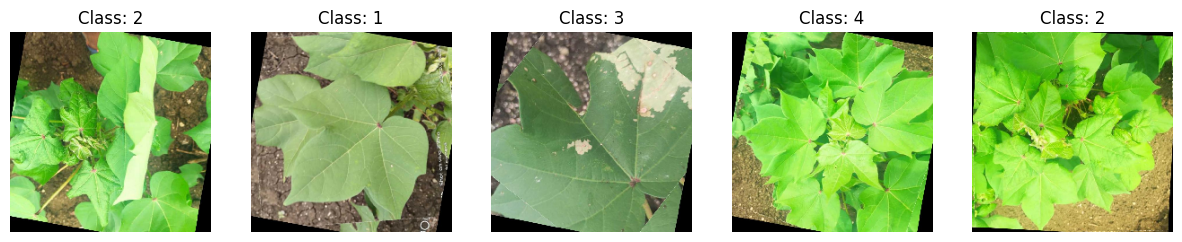

In [ ]:
# Function to display sample images from the dataset
def display_sample_images(images, labels, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(f"Class: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.show()

# Display 5 sample images from the training dataset
display_sample_images(X_train, y_train)

In [ ]:
# One-hot encode labels
num_classes = y_train.shape[1]
y_train = to_categorical(np.argmax(y_train, axis=1), num_classes)
y_valid = to_categorical(np.argmax(y_valid, axis=1), num_classes)
y_test = to_categorical(np.argmax(y_test, axis=1), num_classes)

# Flatten the images for SVM and Random Forest
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_valid_flat = X_valid.reshape(X_valid.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [ ]:
# Define model building function
def build_model(base_model):
    base_model.trainable = False
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Build and train ResNet50
resnet_base = ResNet50(include_top=False, input_shape=(224, 224, 3))
resnet_model = build_model(resnet_base)

history_resnet = resnet_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=10
)

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/10
63/63 [==============================] - 493s 8s/step - loss: 4.1858 - accuracy: 0.3730 - val_loss: 1.0025 - val_accuracy: 0.5895
Epoch 2/10
63/63 [==============================] - 499s 8s/step - loss: 1.3147 - accuracy: 0.5575 - val_loss: 2.4528 - val_accuracy: 0.4789
Epoch 3/10
63/63 [==============================] - 486s 8s/step - loss: 1.4161 - accuracy: 0.5745 - val_loss: 1.5340 - val_accuracy: 0.4053
Epoch 4/10
63/63 [==============================] - 485s 8s/step - loss: 1.2436 - accuracy: 0.6205 - val_loss: 1.0643 - val_accuracy: 0.5947
Epoch 5/10
63/63 [==============================] - 483s 8s/step - loss: 1.1323 - accuracy: 0.6080 - val_loss: 1.0959 - val_accuracy: 0.5421
Epoch 6/10
63/63 [==============================] - 482s 8s/step - loss: 0.9336 - accuracy: 0.6535 - val_loss: 0.7862 - val_accuracy: 0.6579
Epoch 7/10
63/63 [==============================] - 480s 8s/step - loss: 0.8420 - accurac

In [ ]:
# Build and train VGG-16
vgg_base = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg_model = build_model(vgg_base)

history_vgg = vgg_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=10
)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
63/63 [==============================] - 1401s 22s/step - loss: 1.4082 - accuracy: 0.6840 - val_loss: 0.3303 - val_accuracy: 0.8579
Epoch 2/10
63/63 [==============================] - 1397s 22s/step - loss: 0.1920 - accuracy: 0.9285 - val_loss: 0.3588 - val_accuracy: 0.8789
Epoch 3/10
63/63 [==============================] - 1394s 22s/step - loss: 0.1091 - accuracy: 0.9670 - val_loss: 0.2421 - val_accuracy: 0.9053
Epoch 4/10
63/63 [==============================] - 1391s 22s/step - loss: 0.0530 - accuracy: 0.9890 - val_loss: 0.3121 - val_accuracy: 0.9105
Epoch 5/10
63/63 [==============================] - 1393s 22s/step - loss: 0.0311 - accuracy: 0.9945 - val_loss: 0.2330 - val_accuracy: 0.9105
Epoch 6/10
63/63 [==============================] - 1397s 22s/step - loss: 0.0141 - accuracy: 0.9985 - val_loss: 0.3275 - val_accuracy: 0.9105
Epoch 7/10
63/63 [==============================] - 1411s 22s/step - loss: 0.

In [ ]:
# Evaluate the models
def evaluate_model(model, X, y):
    predictions = model.predict(X)
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(y, axis=1)



    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Get metrics for ResNet50
resnet_metrics = evaluate_model(resnet_model, X_test, y_test)
print("ResNet50 Metrics: Accuracy:", resnet_metrics[0], "Precision:", resnet_metrics[1], "Recall:", resnet_metrics[2], "F1 Score:", resnet_metrics[3])

# Get metrics for VGG-16
vgg_metrics = evaluate_model(vgg_model, X_test, y_test)
print("VGG-16 Metrics: Accuracy:", vgg_metrics[0], "Precision:", vgg_metrics[1], "Recall:", vgg_metrics[2], "F1 Score:", vgg_metrics[3])

3/3 [==============================] - 18s 6s/step
ResNet50 Metrics: Accuracy: 0.7222222222222222 Precision: 0.8002645502645502 Recall: 0.7222222222222222 F1 Score: 0.6652338656260225
3/3 [==============================] - 58s 19s/step
VGG-16 Metrics: Accuracy: 0.9777777777777777 Precision: 0.9786848072562357 Recall: 0.9777777777777777 F1 Score: 0.9776533477922366


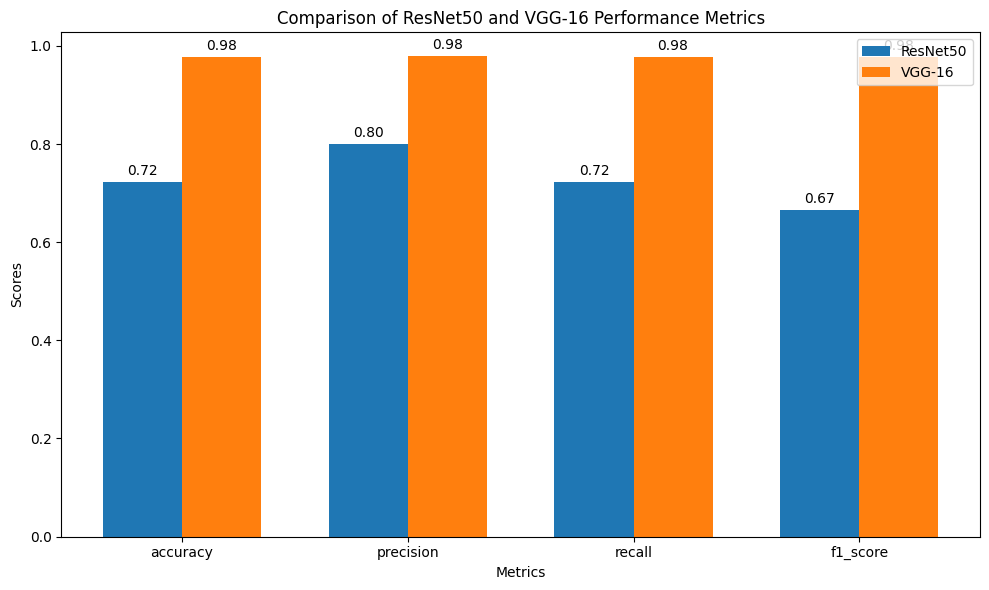

In [ ]:
# Extract metrics for plotting
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
resnet_scores = [resnet_metrics[0], resnet_metrics[1], resnet_metrics[2], resnet_metrics[3]]
vgg_scores = [vgg_metrics[0], vgg_metrics[1], vgg_metrics[2], vgg_metrics[3]]

# Set up the bar plot
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, resnet_scores, width, label='ResNet50')
bars2 = ax.bar(x + width/2, vgg_scores, width, label='VGG-16')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of ResNet50 and VGG-16 Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Attach a text label above each bar in *bars*, displaying its height.
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('%.2f' % height,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

fig.tight_layout()

plt.show()

In [ ]:
# Define and train a simple CNN model
cnn_model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history_cnn = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=10
)

Epoch 1/10
63/63 [==============================] - 228s 4s/step - loss: 10.0610 - accuracy: 0.4140 - val_loss: 1.1325 - val_accuracy: 0.5053
Epoch 2/10
63/63 [==============================] - 200s 3s/step - loss: 0.8947 - accuracy: 0.6685 - val_loss: 1.0225 - val_accuracy: 0.5737
Epoch 3/10
63/63 [==============================] - 202s 3s/step - loss: 0.5581 - accuracy: 0.8080 - val_loss: 0.9425 - val_accuracy: 0.6474
Epoch 4/10
63/63 [==============================] - 206s 3s/step - loss: 0.3047 - accuracy: 0.9075 - val_loss: 1.0382 - val_accuracy: 0.6316
Epoch 5/10
63/63 [==============================] - 205s 3s/step - loss: 0.1521 - accuracy: 0.9645 - val_loss: 0.9444 - val_accuracy: 0.6579
Epoch 6/10
63/63 [==============================] - 204s 3s/step - loss: 0.0420 - accuracy: 0.9990 - val_loss: 1.1921 - val_accuracy: 0.6526
Epoch 7/10
63/63 [==============================] - 202s 3s/step - loss: 0.0170 - accuracy: 1.0000 - val_loss: 1.2845 - val_accuracy: 0.6368
Epoch 8/10
6

CNN Model Evaluation:
3/3 [==============================] - 2s 469ms/step
CNN Classification Report:
               precision    recall  f1-score   support

           1       0.91      0.53      0.67        19
           2       0.79      0.98      0.88        47
           3       0.75      0.60      0.67        10
           4       0.62      0.57      0.59        14

    accuracy                           0.78        90
   macro avg       0.77      0.67      0.70        90
weighted avg       0.79      0.78      0.76        90



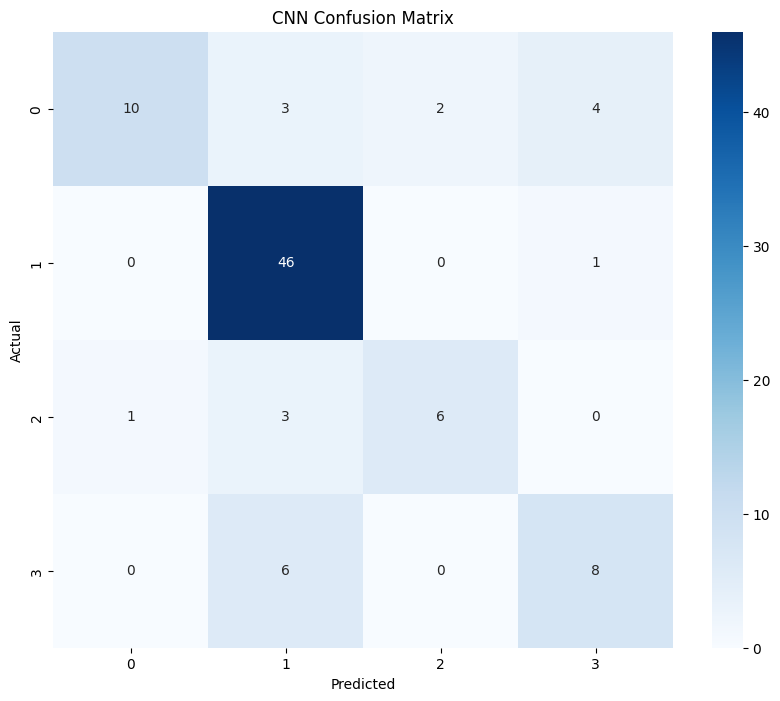

CNN Metrics: Accuracy: 0.7777777777777778 Precision: 0.785155266189749 Recall: 0.7777777777777778 F1 Score: 0.7645620223398001
SVM Model Evaluation:
SVM Classification Report:
               precision    recall  f1-score   support

           1       0.61      1.00      0.76        19
           2       0.84      0.55      0.67        47
           3       0.35      0.60      0.44        10
           4       0.55      0.43      0.48        14

    accuracy                           0.63        90
   macro avg       0.59      0.65      0.59        90
weighted avg       0.69      0.63      0.63        90



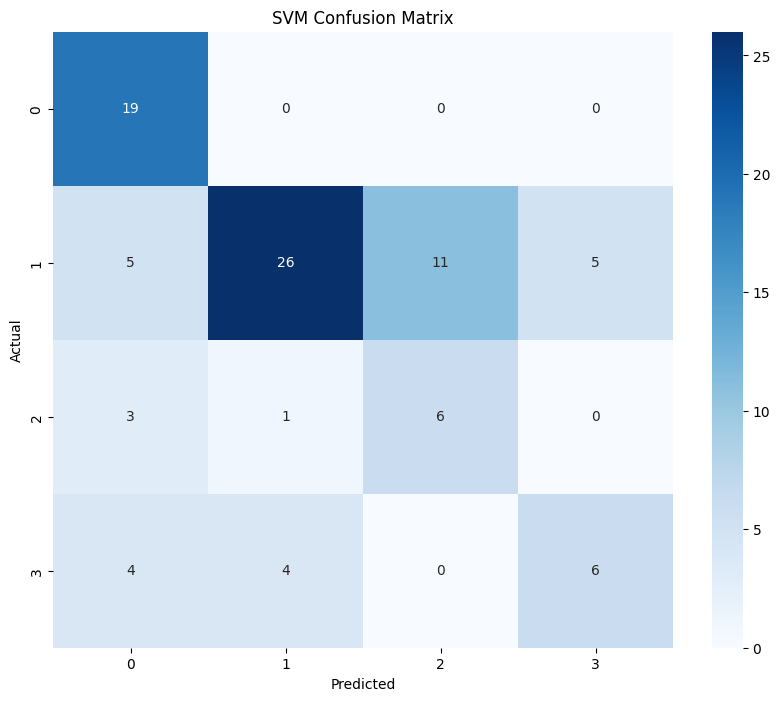

SVM Metrics: Accuracy: 0.6333333333333333 Precision: 0.6914476836677975 Recall: 0.6333333333333333 F1 Score: 0.632641975308642
Random Forest Model Evaluation:
RF Classification Report:
               precision    recall  f1-score   support

           1       0.67      0.63      0.65        19
           2       0.77      0.87      0.82        47
           3       0.75      0.60      0.67        10
           4       0.73      0.57      0.64        14

    accuracy                           0.74        90
   macro avg       0.73      0.67      0.69        90
weighted avg       0.74      0.74      0.74        90



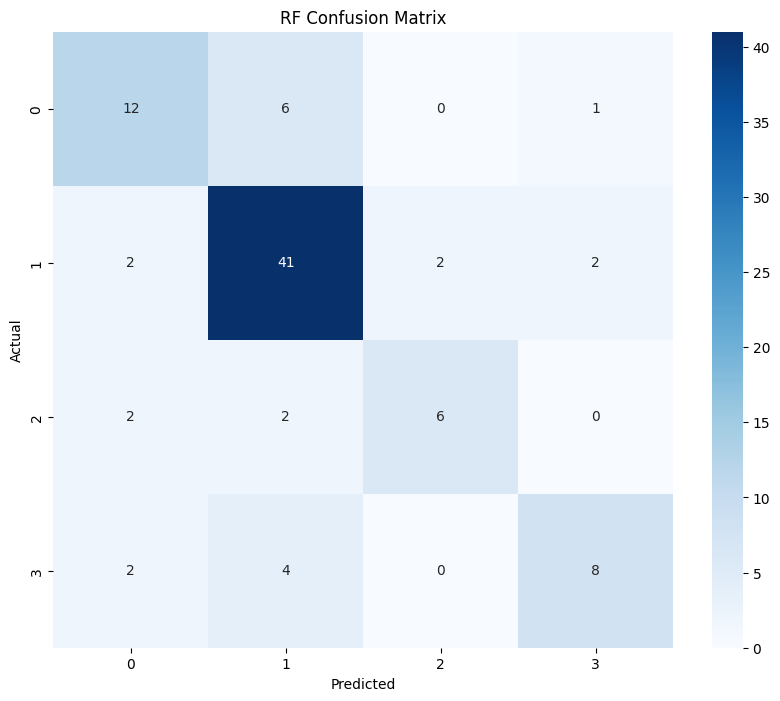

Random Forest Metrics: Accuracy: 0.7444444444444445 Precision: 0.7411886157169176 Recall: 0.7444444444444445 F1 Score: 0.7387887887887888


In [ ]:
# Train a Support Vector Machine (SVM) model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_flat, np.argmax(y_train, axis=1))

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, np.argmax(y_train, axis=1))

# Evaluate the models
def evaluate_model(model, X, y, model_name):
    predictions = model.predict(X)
    y_pred = np.argmax(predictions, axis=1) if model_name == 'cnn' else model.predict(X)
    y_true = np.argmax(y, axis=1)

    print(f"{model_name.upper()} Classification Report:\n", classification_report(y_true, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'{model_name.upper()} Confusion Matrix')
    plt.show()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Get metrics for CNN
print("CNN Model Evaluation:")
cnn_metrics = evaluate_model(cnn_model, X_test, y_test, 'cnn')
print("CNN Metrics: Accuracy:", cnn_metrics[0], "Precision:", cnn_metrics[1], "Recall:", cnn_metrics[2], "F1 Score:", cnn_metrics[3])

# Get metrics for SVM
print("SVM Model Evaluation:")
svm_metrics = evaluate_model(svm_model, X_test_flat, y_test, 'svm')
print("SVM Metrics: Accuracy:", svm_metrics[0], "Precision:", svm_metrics[1], "Recall:", svm_metrics[2], "F1 Score:", svm_metrics[3])

# Get metrics for Random Forest
print("Random Forest Model Evaluation:")
rf_metrics = evaluate_model(rf_model, X_test_flat, y_test, 'rf')
print("Random Forest Metrics: Accuracy:", rf_metrics[0], "Precision:", rf_metrics[1], "Recall:", rf_metrics[2], "F1 Score:", rf_metrics[3])

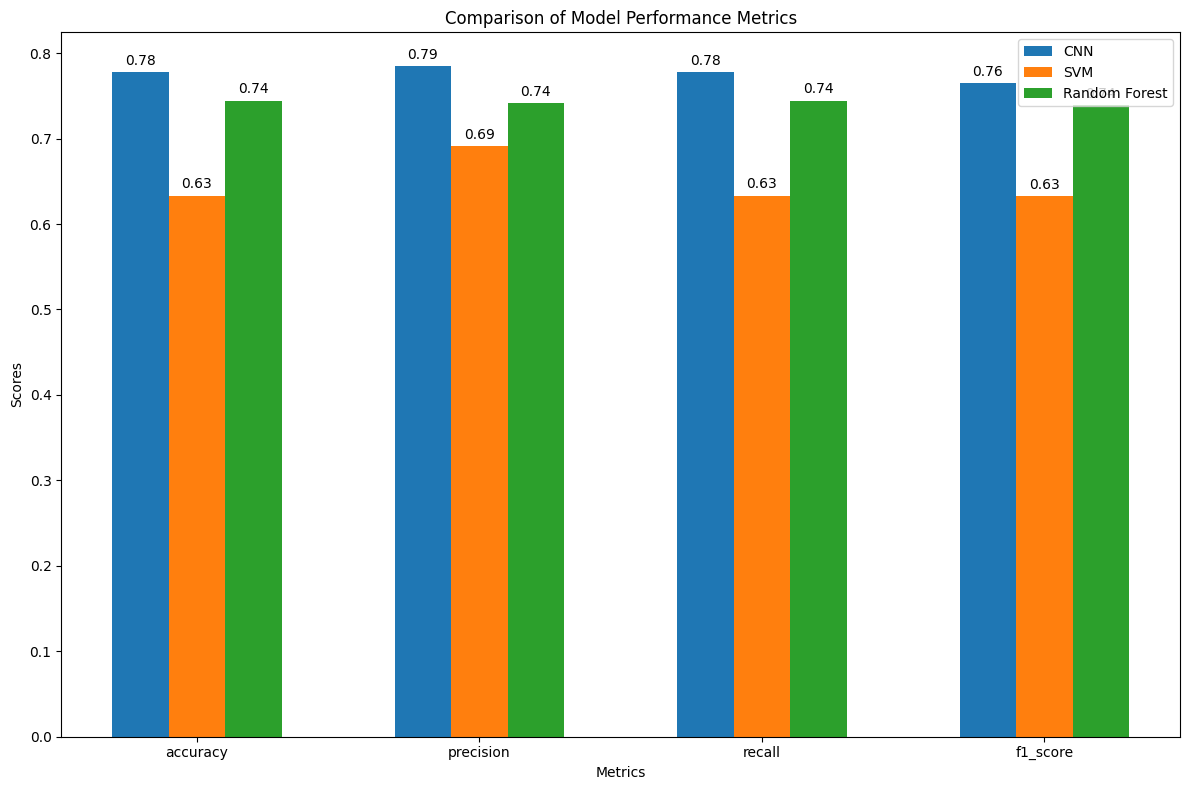

In [ ]:
# Extract metrics for plotting
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
cnn_scores = [cnn_metrics[0], cnn_metrics[1], cnn_metrics[2], cnn_metrics[3]]
svm_scores = [svm_metrics[0], svm_metrics[1], svm_metrics[2], svm_metrics[3]]
rf_scores = [rf_metrics[0], rf_metrics[1], rf_metrics[2], rf_metrics[3]]

# Set up the bar plot
x = np.arange(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 8))
bars1 = ax.bar(x - width, cnn_scores, width, label='CNN')
bars2 = ax.bar(x, svm_scores, width, label='SVM')
bars3 = ax.bar(x + width, rf_scores, width, label='Random Forest')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Attach a text label above each bar in *bars*, displaying its height.
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('%.2f' % height,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)

fig.tight_layout()
plt.show()